### 原始GAN的问题

GAN训练有一个trick，就是别把判别器训练得太好，否则在实验中生成器会完全学不动（loss降不下去）。为什么？  
在原始损失函数基础上，最优分类器（交叉熵求导取0）带入损失函数中，得到：
$$
2 J S\left(P_{r} \| P_{g}\right)-2 \log 2
$$
其中：
$$
K L\left(P_{1} \| P_{2}\right)=\mathbb{E}_{x \sim P_{1}} \log \frac{P_{1}}{P_{2}}
$$
$$
J S\left(P_{1} \| P_{2}\right)=\frac{1}{2} K L\left(P_{1} \| \frac{P_{1}+P_{2}}{2}\right)+\frac{1}{2} K L\left(P_{2} \| \frac{P_{1}+P_{2}}{2}\right)
$$

最小化JS散度是目标。但是：
- 当判别器训太准确，$P_r$与$P_g$不重叠概率近乎为1，JS在BP求导时的结果为0，导致梯度消失。
>当$P_r$与$P_g$的支撑集（support）是高维空间中的低维流形（manifold）时，$P_r$与$P_g$重叠部分测度（measure）为0的概率为1
- 当判别器训不准确，生成器得到梯度也不准确，导致模型不够稳定。

### 修改后的LOSS FUNCTION

$$
\mathbb{E}_{x \sim P_{g}}[-\log D(x)]
$$
生成器loss改变了，导致在最优判别器下，整体loss为：
$$
K L\left(P_{g} \| P_{r}\right)-2 J S\left(P_{r} \| P_{g}\right)
$$
问题依然存在：
- 最小化生成分布与真实分布的KL散度，却又要最大化两者的JS散度，一个要拉近，一个却要推远
- KL散度不是一个对称的衡量。$K L\left(P_{g} \| P_{r}\right)$对生成器没能生成多样性的样本”，惩罚小；而对“生成器生成了不真实的样本” ，惩罚大
collapse mode出现。大致如下图所示：
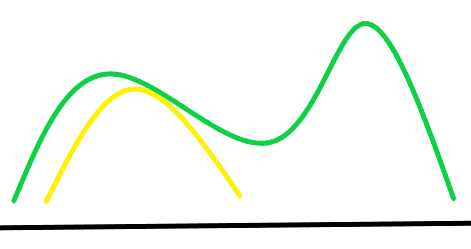

### Solutions

#### 加噪声：
解决了训练不稳定的问题，不需要小心平衡判别器训练，可以放心地把判别器训练到接近最优，但是仍然没能够提供一个衡量训练进程的数值指标。

#### Wasserstein距离

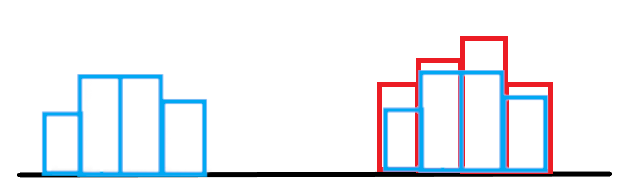

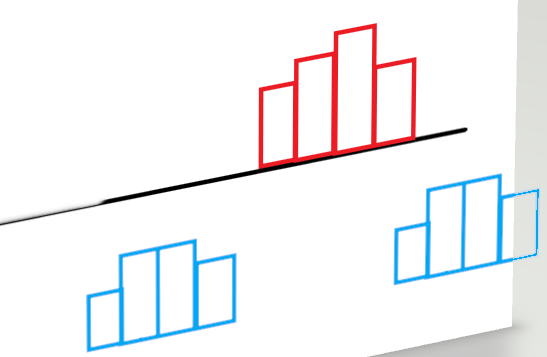

分布1到分布2的最小‘消耗’度量。  
Wasserstein距离相比KL散度、JS散度的优越性在于，即便两个分布没有重叠，Wasserstein距离仍然能够反映它们的远近。

$$
W\left(P_{r}, P_{g}\right)=\inf _{\gamma \sim \Pi\left(P_{r}, P_{g}\right)} \mathbb{E}_{(x, y) \sim \gamma}[\|x-y\|]
$$

即，在$(P_{r}, P_{g})$联合分布下，抽样得到x和y，求得两者距离的下界

然后，作者将“下界”的，通过以下方法计算：
$$
W\left(P_{r}, P_{g}\right)=\frac{1}{K} \sup _{\|f\|_{L} \leq K} \mathbb{E}_{x \sim P_{r}}[f(x)]-\mathbb{E}_{x \sim P_{g}}[f(x)]
$$
$\left\|f_{w}\right\|_{L} \leq K$指Lipschitz常数不超过K，即

$$
\left|f\left(x_{1}\right)-f\left(x_{2}\right)\right| \leq K\left|x_{1}-x_{2}\right|
$$

保证了导数的上界不会太大，即，函数局部变化量不大。
实际使用时，K取1，在算法实现中，每次更新完w后把它clip回某个范围。

$$
L=\mathbb{E}_{x \sim P_{r}}\left[f_{w}(x)\right]-\mathbb{E}_{x \sim P_{g}}\left[f_{w}(x)\right]
$$

即为，最终的Loss

> 原始GAN的判别器做的是真假二分类任务，所以最后一层是sigmoid，但是现在WGAN中的判别器做的是近似拟合Wasserstein距离，属于回归任务，所以要把最后一层的sigmoid拿掉

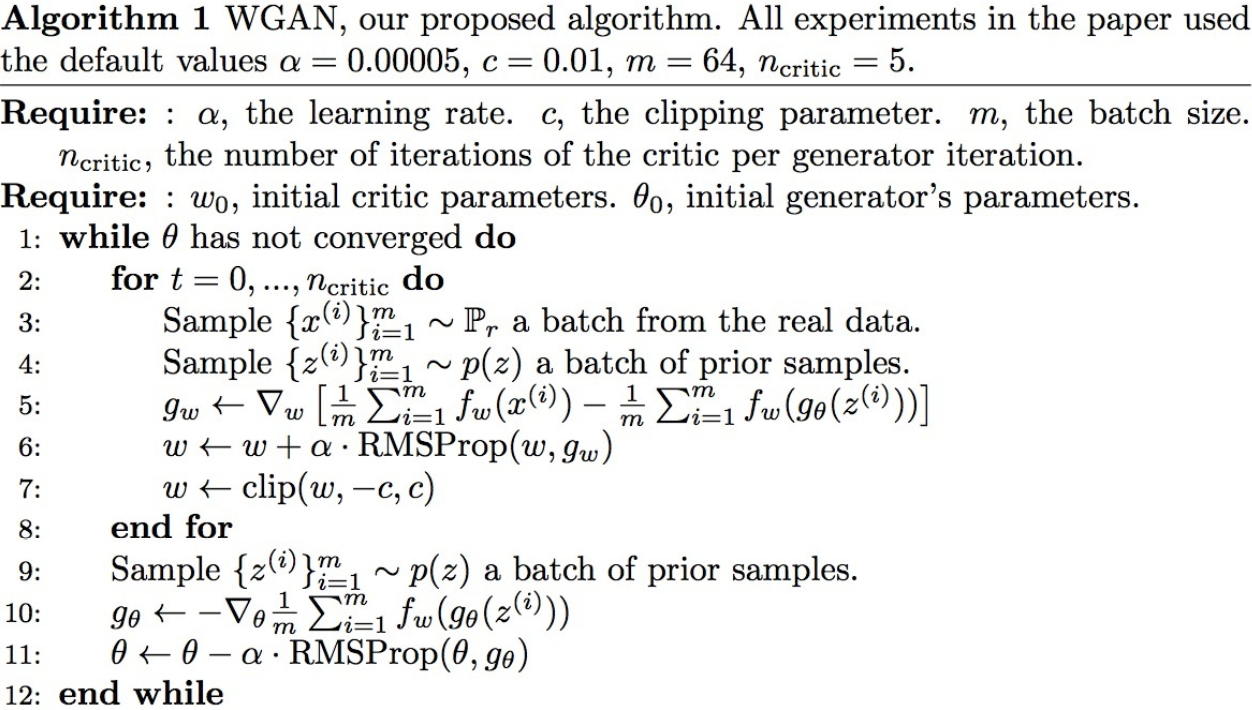

WGAN与原始GAN第一种形式相比，只改了四点：
- 判别器最后一层去掉sigmoid
- 生成器和判别器的loss不取log
- 每次更新判别器的参数之后把它们的绝对值截断到不超过一个固定常数c
- 不要用基于动量的优化算法（包括momentum和Adam），推荐RMSProp，SGD也行  
> 作者发现如果使用Adam，Adam给出的更新方向与梯度方向夹角的cos值就变成负数。

对比DCGAN：WGAN不用DCGAN各种特殊的架构设计也能做到不错的效果，
- 比如不用Batch Normalization，WGAN依然可以训练学习；
- 多层全连接网络（MLP），不用CNN，WGAN依然可以训练学习；

### wgan face generation

In [1]:
import tensorflow as tf
import numpy as np
import os
import matplotlib.pyplot as plt
%matplotlib inline
from imageio import imread, imsave, mimsave
import cv2
import glob
from tqdm import tqdm

In [ ]:
# dataset = 'lfw_new_imgs' # LFW：https://link.zhihu.com/?target=http%3A//vis-www.cs.umass.edu/lfw/
dataset = 'celeba' # CelebA：https://link.zhihu.com/?target=http%3A//mmlab.ie.cuhk.edu.hk/projects/CelebA.html
images = glob.glob(os.path.join(dataset, '*.*')) 
print(len(images))

In [3]:
batch_size = 100
z_dim = 100
WIDTH = 64
HEIGHT = 64
LAMBDA = 10
DIS_ITERS = 3 # 5  n critic

OUTPUT_DIR = 'samples_' + dataset
if not os.path.exists(OUTPUT_DIR):
    os.mkdir(OUTPUT_DIR)

#### input

In [4]:
# 真实图片
X = tf.placeholder(dtype=tf.float32, shape=[batch_size, HEIGHT, WIDTH, 3], name='X')
# 生成器输入噪声
noise = tf.placeholder(dtype=tf.float32, shape=[batch_size, z_dim], name='noise')
is_training = tf.placeholder(dtype=tf.bool, name='is_training')

#### Layers

In [5]:
def lrelu(x, leak=0.2): return tf.maximum(x, leak * x)


def discriminator(image, reuse=None):
    """简单CNN、FC，输出回归预测值"""
    with tf.variable_scope('discriminator', reuse=reuse):
        h0 = lrelu(tf.layers.conv2d(image, kernel_size=5, filters=64, strides=2, padding='same'))
        h1 = lrelu(tf.layers.conv2d(h0, kernel_size=5, filters=128, strides=2, padding='same'))
        h2 = lrelu(tf.layers.conv2d(h1, kernel_size=5, filters=256, strides=2, padding='same'))
        h3 = lrelu(tf.layers.conv2d(h2, kernel_size=5, filters=512, strides=2, padding='same'))
        
        h4 = tf.contrib.layers.flatten(h3)
        h4 = tf.layers.dense(h4, units=1)
        return h4
    
    
def generator(z, is_training=is_training, momentum=0.9):
    """反卷积，返回真实图片相同维度"""
    with tf.variable_scope('generator', reuse=None):
        d = 4
        h0 = tf.layers.dense(z, units=d * d * 512)
        h0 = tf.reshape(h0, shape=[-1, d, d, 512])
        h0 = tf.nn.relu(tf.contrib.layers.batch_norm(h0, is_training=is_training, decay=momentum))
        
        h1 = tf.layers.conv2d_transpose(h0, kernel_size=5, filters=256, strides=2, padding='same')
        h1 = tf.nn.relu(tf.contrib.layers.batch_norm(h1, is_training=is_training, decay=momentum))
        
        h2 = tf.layers.conv2d_transpose(h1, kernel_size=5, filters=128, strides=2, padding='same')
        h2 = tf.nn.relu(tf.contrib.layers.batch_norm(h2, is_training=is_training, decay=momentum))
        
        h3 = tf.layers.conv2d_transpose(h2, kernel_size=5, filters=64, strides=2, padding='same')
        h3 = tf.nn.relu(tf.contrib.layers.batch_norm(h3, is_training=is_training, decay=momentum))
        
        h4 = tf.layers.conv2d_transpose(h3, kernel_size=5, filters=3, strides=2, padding='same', activation=tf.nn.tanh, name='g')
        return h4

#### Graph

In [6]:
g = generator(noise)
d_real = discriminator(X)
d_fake = discriminator(g, reuse=True)

# 损失值，只是简单计算discriminator的结果
loss_d_real = -tf.reduce_mean(d_real)
loss_d_fake = tf.reduce_mean(d_fake)
loss_g = -tf.reduce_mean(d_fake)
loss_d = loss_d_real + loss_d_fake

In [7]:
# gradient penalty
# 对真实图片和生成图片进行线性插值
alpha = tf.random_uniform(shape=[batch_size, 1, 1, 1], minval=0., maxval=1.)
interpolates = alpha * X + (1 - alpha) * g

# 用偏导数计算整体梯度（slop）
grad = tf.gradients(discriminator(interpolates, reuse=True), [interpolates])[0]
slop = tf.sqrt(tf.reduce_sum(tf.square(grad), axis=[1]))
gp = tf.reduce_mean((slop - 1.) ** 2)
loss_d += LAMBDA * gp

In [9]:
# 分别建立生成器和判别器的BP计算路径
vars_g = [var for var in tf.trainable_variables() if var.name.startswith('generator')]
vars_d = [var for var in tf.trainable_variables() if var.name.startswith('discriminator')]

update_ops = tf.get_collection(tf.GraphKeys.UPDATE_OPS)
with tf.control_dependencies(update_ops):
    optimizer_d = tf.train.AdamOptimizer(learning_rate=0.0002, beta1=0.5).minimize(loss_d, var_list=vars_d)
    optimizer_g = tf.train.AdamOptimizer(learning_rate=0.0002, beta1=0.5).minimize(loss_g, var_list=vars_g)

#### train

In [10]:
from utils import read_image, get_random_batch, montage

In [11]:
sess = tf.Session()
sess.run(tf.global_variables_initializer())
z_samples = np.random.uniform(-1.0, 1.0, [batch_size, z_dim]).astype(np.float32)
samples = []
loss = {'d': [], 'g': []}

In [ ]:
for i in tqdm(range(60000)):
    # 算法中n critic部分
    for j in range(DIS_ITERS):
        n = np.random.uniform(-1.0, 1.0, [batch_size, z_dim]).astype(np.float32)
        batch = get_random_batch(batch_size)
        _, d_ls = sess.run([optimizer_d, loss_d], feed_dict={X: batch, noise: n, is_training: True})
    
    _, g_ls = sess.run([optimizer_g, loss_g], feed_dict={X: batch, noise: n, is_training: True})
    
    loss['d'].append(d_ls)
    loss['g'].append(g_ls)
    
    if i % 500 == 0:
        print(i, d_ls, g_ls)
        gen_imgs = sess.run(g, feed_dict={noise: z_samples, is_training: False})
        gen_imgs = (gen_imgs + 1) / 2
        
        imgs = [img[:, :, :] for img in gen_imgs]
        gen_imgs = montage(imgs)
        plt.axis('off')
        plt.imshow(gen_imgs)
        imsave(os.path.join(OUTPUT_DIR, 'sample_%d.jpg' % i), gen_imgs)
        plt.show()
        samples.append(gen_imgs)

saver = tf.train.Saver()
saver.save(sess, os.path.join(OUTPUT_DIR, 'wgan_' + dataset), global_step=60000)        

plt.plot(loss['d'], label='Discriminator')
plt.plot(loss['g'], label='Generator')
plt.legend(loc='upper right')
plt.savefig(os.path.join(OUTPUT_DIR, 'Loss.png'))
plt.show()
mimsave(os.path.join(OUTPUT_DIR, 'samples.gif'), samples, fps=10)
